In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/behav_neuro_fit/

/content/drive/MyDrive/Work/Sciencing/Google_CoLab_projects/WWD_Model/WWD_pytorch/github/behav_neuro_fit


In [6]:
import pandas as pd
import numpy as np
import scipy.io
import sys
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [4]:
sys.path.append('code/')

In [5]:
from hgf_fitting import hgf_fitting


In [7]:
model = hgf_fitting()

In [48]:
u = np.concatenate([bernoulli.rvs(0.5, size=500), bernoulli.rvs(0.8, size =100), bernoulli.rvs(0.2, size =100),  \
                    bernoulli.rvs(0.8, size =100), bernoulli.rvs(0.2, size =100),  bernoulli.rvs(0.8, size =100),\
                    bernoulli.rvs(0.2, size =100),  bernoulli.rvs(0.5, size =300)])

uy = np.concatenate([bernoulli.rvs(0.5, size=500), bernoulli.rvs(0.6, size =100), bernoulli.rvs(0.4, size =100),  \
                    bernoulli.rvs(0.6, size =100), bernoulli.rvs(0.4, size =100),  bernoulli.rvs(0.6, size =100),\
                    bernoulli.rvs(0.4, size =100),  bernoulli.rvs(0.5, size =300)])

In [49]:
u_bar = np.concatenate([0.5*np.ones((500,)), np.ones((100,)), np.zeros((100,)),  \
                    np.ones((100,)), np.zeros((100,)),  np.ones((100,)),\
                    np.zeros((100,)),  0.5*np.ones((300,))])

In [50]:
### get bayesian optimal model for input signals
yv=[]
x2v=[]
x3v=[]
mu =[]
mu2v=[]
mu3v=[]
var2v=[]
var3v=[]
wv=[]
kv=[]
thetav=[]
p1v=[]
p2v=[]
# initals for model states and parameters
x2 = .1
x3= 0.02
mu2=0.2
mu3=0.1
var2=.25
var3=.08
w= -.8
k=.4
theta= .04

# a vettor with all states and parameters for fitting
X = np.array([x3,mu3, var3, theta, x2, mu2, var2, k, w])

# initial for grad and hess
grad = np.zeros((9,))
hess = np.zeros((9,))

# fitting
for i in range(u.shape[0]):
    #print(i)
    v=u[i]
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]


    # calculate the grad and hess at the top level
    grad_t, hess_t = model.hess_grad_top(x3, mu3, var3, theta)
    # update total grad and hess
    grad[:4] = grad_t
    hess[:4] = hess_t
    
    # calculate the grad and hess at mid levels
    grad_m, hess_m = model.hess_grad_mid(x2, mu2, var2, k, w, x3)
    # update the total grad and hess
    grad[4:] = grad_m[:5]
    hess[4:] = hess_m[:5]
    grad[0] += grad_m[-1] # update grad on x3 from this level
    hess[0] += hess_m[-1] # update hess on x3 from this level

    

    # update model states and parameters by Euler method
    X = model.update(v, X, grad, hess)
    
    # making sure the var2 var3 and theta are positive 
    X[2] = model.relu(X[2])
    X[3] = model.relu(X[3])
    X[6] = model.relu(X[6])
    
    # save the new states and model parameters
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]
    
    x2v.append(x2)
    x3v.append(x3)
    mu2v.append(mu2)
    mu3v.append(mu3)
    var2v.append(var2)
    var3v.append(var3)
    wv.append(w)
    kv.append(k)
    thetav.append(theta)

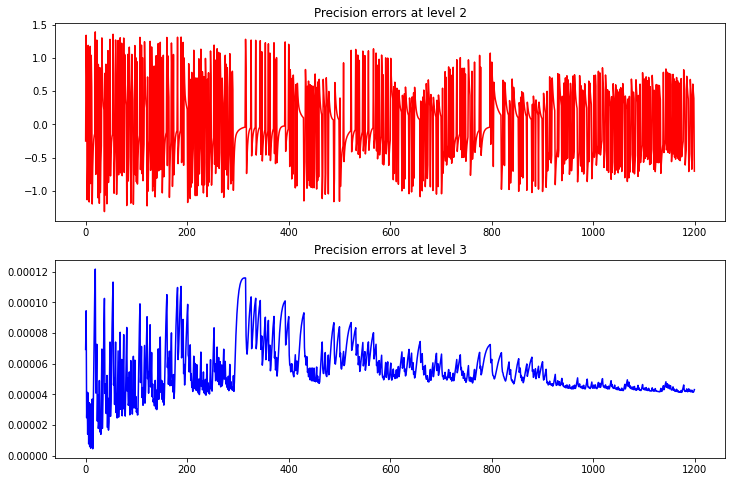

In [51]:
# calculate PE signals and show them
x2 =np.array(x2v)
k =np.array(kv)
w =np.array(wv)

x3 =np.array(x3v)
var2 =np.array(var2v)
var3 =np.array(var3v)
theta =np.array(thetav)
mu2 =np.array(mu2v)
mu3 =np.array(mu3v)

sigma_x = model.sigmoid(x2)
sigma_dx = model.sigmoid_dx(x2)
sigma_dxx = model.sigmoid_dxx(x2)
var2hat = var2+np.exp(k*x3+w)
var3hat = var3+theta
s2 = (x2-mu2)/np.sqrt(var2hat)
s3 = (x3-mu3)/np.sqrt(var3hat)
fig, ax =plt.subplots(2,1, figsize=(12,8))

ax[0].plot(-s2[200:], 'r')
ax[0].set_title('Precision errors at level 2')
ax[1].plot(-s3[200:], 'b')
ax[1].set_title('Precision errors at level 3')

plt.show()

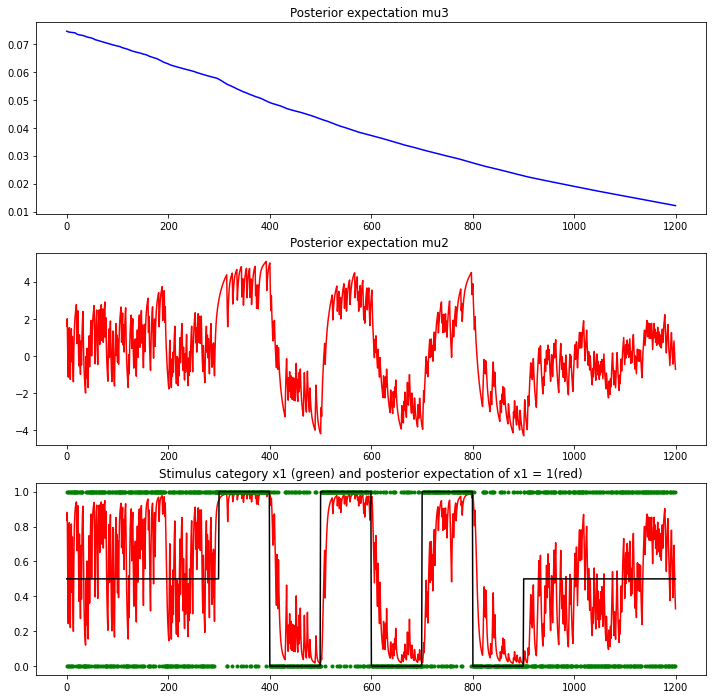

In [52]:
# show the bayesian optimial solutions:
fig, ax =plt.subplots(3,1, figsize=(12,12))
ax[0].plot(mu3[200:], 'b')
ax[0].set_title('Posterior expectation mu3 ')
ax[1].plot(mu2[200:], 'r')
ax[1].set_title('Posterior expectation mu2 ')
ax[2].plot(model.sigmoid(mu2)[200:],'r')
ax[2].plot(u[200:], 'g.')
ax[2].plot(u_bar[200:],'black')
ax[2].set_title('Stimulus category x1 (green) and posterior expectation of x1 = 1(red)')

plt.show()

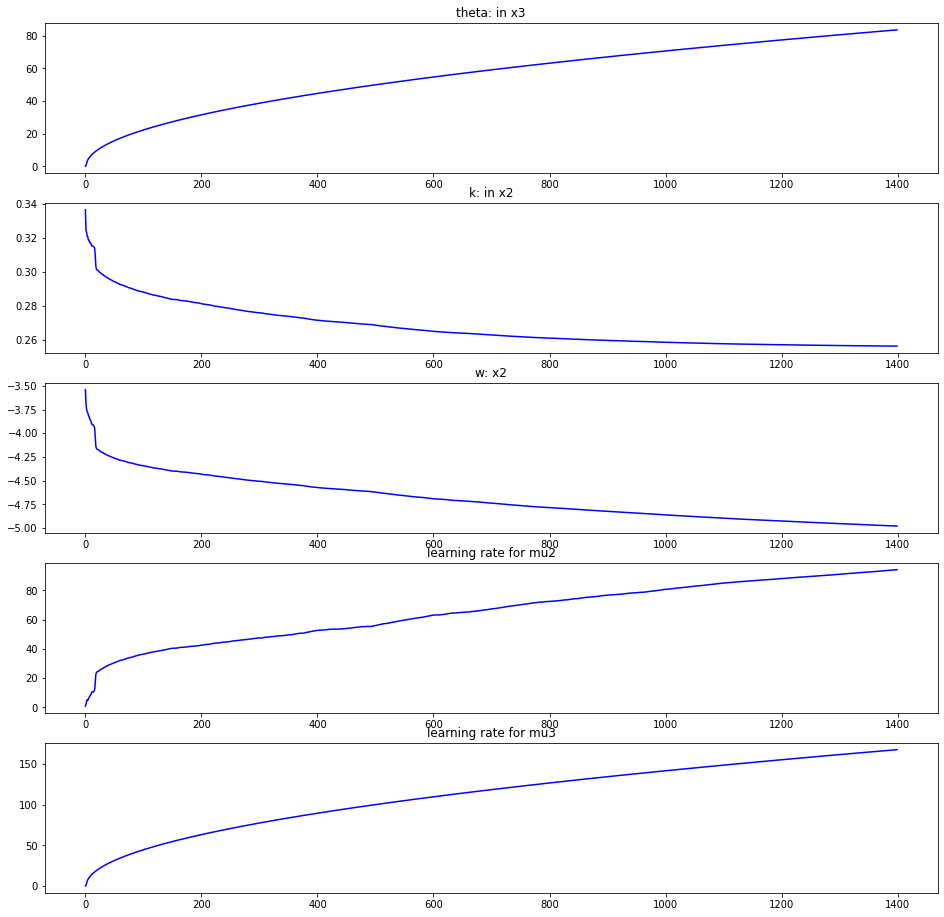

In [53]:
# show the model parameters and learning rate
fig, ax =plt.subplots(5,1, figsize=(16,16))
ax[0].plot(theta, 'b')
ax[0].set_title('theta: in x3')
ax[1].plot(k,'b')
ax[1].set_title('k: in x2')
ax[2].plot(w,'b')
ax[2].set_title('w: x2')
ax[3].plot(var2hat,'b')
ax[3].set_title('learning rate for mu2')
ax[4].plot(var3hat,'b')
ax[4].set_title('learning rate for mu3')
plt.show()

In [54]:
#### fitting response using bayesian optimal signals of inputs
# bayesian optimal mean trends at level 2
ur = np.array(mu2v)
# placeholders for outputs
x2v=[]
x3v=[]

mu2v=[]
mu3v=[]

var2v=[]
var3v=[]
wv=[]
kv=[]
thetav=[]

pv=[]

# initials on model
x2 = .1
x3= 0.02
mu2=0.2
mu3=0.1
var2=.25
var3=.08
w= -.8
k=.4
theta= .04
p=1.2


# vector of all variables
X = np.array([x3,mu3, var3, theta, x2, mu2, var2, k, w, p])

# initials grad and hess
grad = np.zeros((10,))
hess = np.zeros((10,))

# fitting behavior data
for i in range(u.shape[0]):
    #print(i)
    v=ur[i]
    vy=uy[i]
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]
    
    p = 1#X[9] # fix p so k w and theta can represent sub

    # calculate grad and hess at top level
    grad_t, hess_t = model.hess_grad_top(x3, mu3, var3, theta)
    # update the total grad and hess
    grad[:4] = grad_t
    hess[:4] = hess_t

    # calculate grad and hess at mid levels
    grad_m, hess_m = model.hess_grad_mid_res(x2,  mu2, var2, k, w, p, x3, v, vy)
    grad[4:] = grad_m[:6]
    hess[4:] = hess_m[:6]
    grad[0] += grad_m[-1] # update grad on x3 from this level
    hess[0] += hess_m[-1] # update hess on x3 from this level

    

    # update model states and parameters
    X = model.update(vy, X, grad, hess)
    # making sure var theta and p positive
    X[2] = model.relu(X[2])
    X[3] = model.relu(X[3])
    X[6] = model.relu(X[6])
    X[9] = model.relu(X[9])
    
    # save the new updates
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]
    p = 1#X[9]
    
    
    
    x2v.append(x2)
    x3v.append(x3)
    
    mu2v.append(mu2)
    mu3v.append(mu3)
    
    var2v.append(var2)
    var3v.append(var3)
    wv.append(w)
    pv.append(p)
    
    kv.append(k)
    thetav.append(theta)
    

In [16]:
ur.shape

(0,)

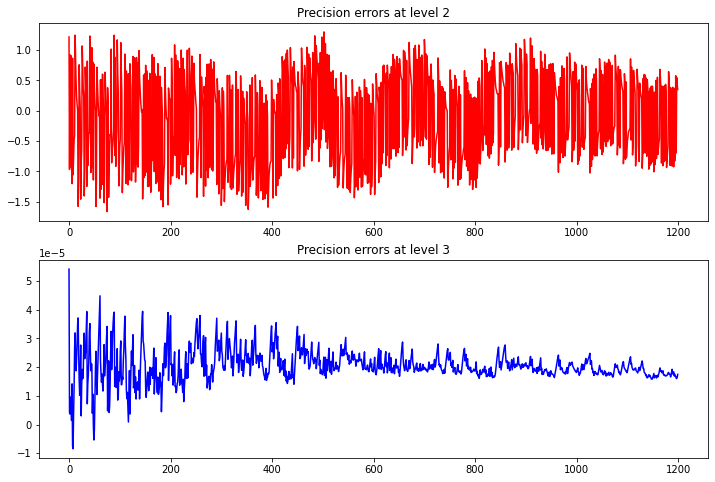

In [55]:
x2 =np.array(x2v)
k =np.array(kv)
w =np.array(wv)
p =np.array(pv)

x3 =np.array(x3v)
var2 =np.array(var2v)
var3 =np.array(var3v)
theta =np.array(thetav)
mu2 =np.array(mu2v)
mu3 =np.array(mu3v)

sigma_x = model.sigmoid(x2)
sigma_dx = model.sigmoid_dx(x2)
sigma_dxx = model.sigmoid_dxx(x2)
var2hat = var2+np.exp(k*x3+w)
var3hat = var3+theta
s2 = (x2-mu2)/np.sqrt(var2hat)
s3 = (x3-mu3)/np.sqrt(var3hat)
fig, ax =plt.subplots(2,1, figsize=(12,8))

ax[0].plot(-s2[200:], 'r')
ax[0].set_title('Precision errors at level 2')
ax[1].plot(-s3[200:], 'b')
ax[1].set_title('Precision errors at level 3')

plt.show()

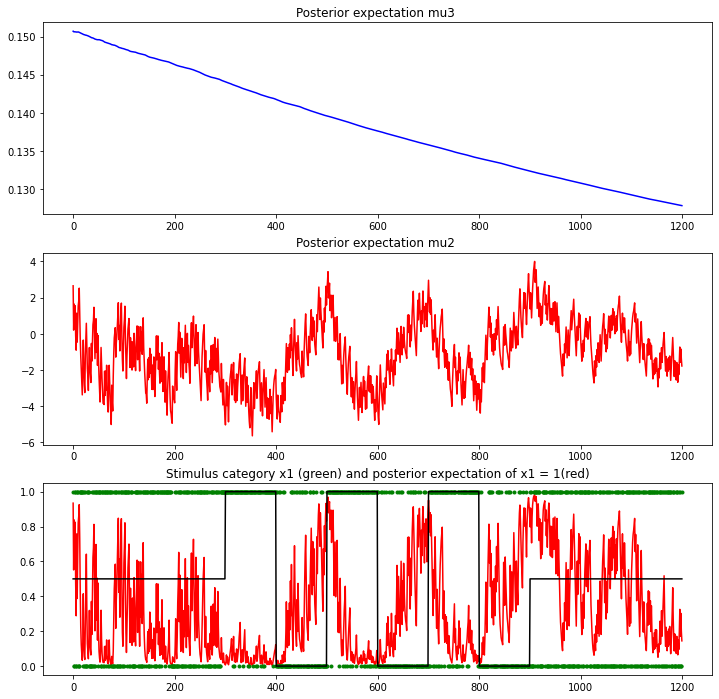

In [56]:
fig, ax =plt.subplots(3,1, figsize=(12,12))
ax[0].plot(mu3[200:], 'b')
ax[0].set_title('Posterior expectation mu3 ')
ax[1].plot(mu2[200:], 'r')
ax[1].set_title('Posterior expectation mu2 ')
ax[2].plot(model.sigmoid(mu2)[200:],'r')
ax[2].plot(u[200:], 'g.')
ax[2].plot(u_bar[200:],'black')
ax[2].set_title('Stimulus category x1 (green) and posterior expectation of x1 = 1(red)')

plt.show()

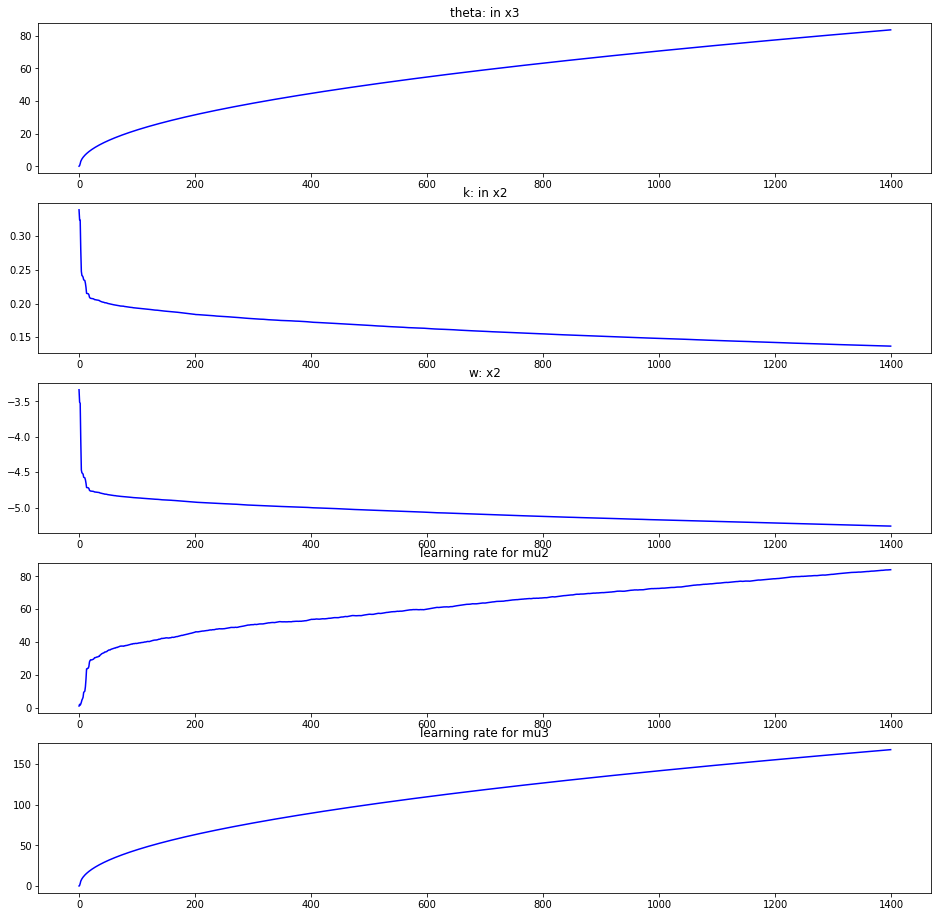

In [57]:
fig, ax =plt.subplots(5,1, figsize=(16,16))
ax[0].plot(theta, 'b')
ax[0].set_title('theta: in x3')
ax[1].plot(k,'b')
ax[1].set_title('k: in x2')
ax[2].plot(w,'b')
ax[2].set_title('w: x2')
ax[3].plot(var2hat,'b')
ax[3].set_title('learning rate for mu2')
ax[4].plot(var3hat,'b')
ax[4].set_title('learning rate for mu3')
plt.show()

In [61]:
data_dir = '/content/drive/MyDrive/Work/Sciencing/Data/DMPAD_168/'
input_file = data_dir + 'behav/DMPAD_160_inputs.mat'
output_file = data_dir + 'behav/DMPAD_160_outputs.mat'
u = scipy.io.loadmat(input_file)
y = scipy.io.loadmat(output_file)

inp = u['u']
outp =y['y']

raw_file= data_dir +'behav/DMPAD_0168perblock_IOIO_run15_EEG.mat'
raw = scipy.io.loadmat(raw_file)
raw_file=data_dir + 'behav/DMPAD_0168perblock_IOIO_run16_EEG.mat'
raw1 = scipy.io.loadmat(raw_file)
# 1:blue 0:grenn
u_adv = []
u_true = []
for i in range(105):
    u_adv.append((raw['SOC'][0][0][21]%2)[i])
    u_true.append((raw['SOC'][0][0][23]%2)[i])
for i in range(105):
    u_adv.append((raw1['SOC'][0][0][21]%2)[i])
    u_true.append((raw1['SOC'][0][0][23]%2)[i])
u_true= np.array(u_true).astype(int)
u_adv= np.array(u_adv).astype(int)

uy=[]
for i in range(210):
   if outp[i] == 1:
      uy.append(u_adv[i])
   else:
      uy.append(1-u_adv[i])

uy=np.array(uy).astype(int)

In [63]:
### get bayesian optimal model for input signals from advisor
yv=[]
x2v=[]
x3v=[]
mu =[]
mu2v=[]
mu3v=[]
var2v=[]
var3v=[]
wv=[]
kv=[]
thetav=[]
p1v=[]
p2v=[]
# initals for model states and parameters
x2 = .1
x3= 0.02
mu2=.8
mu3=.1
var2=.55
var3=.08
w= 1.1
k=.4
theta= .04

# a vettor with all states and parameters for fitting
X = np.array([x3,mu3, var3, theta, x2, mu2, var2, k, w])

# initial for grad and hess
grad = np.zeros((9,))
hess = np.zeros((9,))
u_test=bernoulli.rvs(0.5, size=50)
# fitting
for i in range(50+len(u_adv)):
    #print(i)
    if i <50:
      v=u_test[i]
    else:
      v=u_true[i-50]
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]


    # calculate the grad and hess at the top level
    grad_t, hess_t = model.hess_grad_top(x3, mu3, var3, theta)
    # update total grad and hess
    grad[:4] = grad_t
    hess[:4] = hess_t
    
    # calculate the grad and hess at mid levels
    grad_m, hess_m = model.hess_grad_mid(x2, mu2, var2, k, w, x3)
    # update the total grad and hess
    grad[4:] = grad_m[:5]
    hess[4:] = hess_m[:5]
    grad[0] += grad_m[-1] # update grad on x3 from this level
    hess[0] += hess_m[-1] # update hess on x3 from this level

    

    # update model states and parameters by Euler method
    X = model.update(v, X, grad, hess)
    
    # making sure the var2 var3 and theta are positive 
    X[2] = model.relu(X[2])
    X[3] = model.relu(X[3])
    X[6] = model.relu(X[6])
    
    # save the new states and model parameters
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]
    
    x2v.append(x2)
    x3v.append(x3)
    mu2v.append(mu2)
    mu3v.append(mu3)
    var2v.append(var2)
    var3v.append(var3)
    wv.append(w)
    kv.append(k)
    thetav.append(theta)

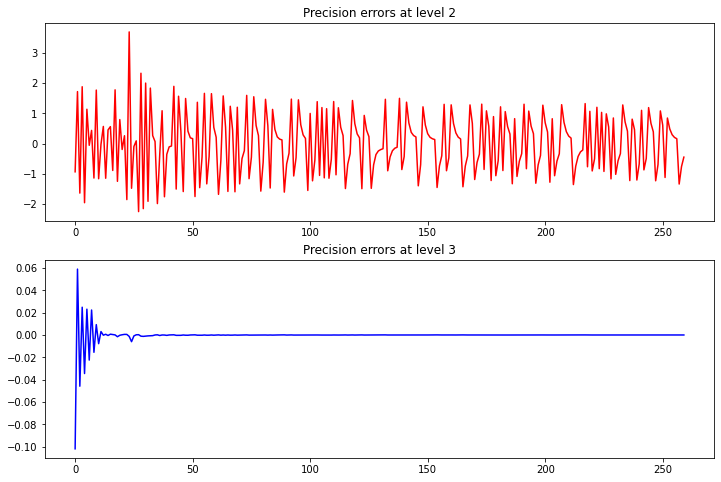

In [64]:
# calculate PE signals and show them
x2 =np.array(x2v)
k =np.array(kv)
w =np.array(wv)

x3 =np.array(x3v)
var2 =np.array(var2v)
var3 =np.array(var3v)
theta =np.array(thetav)
mu2 =np.array(mu2v)
mu3 =np.array(mu3v)

sigma_x = model.sigmoid(x2)
sigma_dx = model.sigmoid_dx(x2)
sigma_dxx = model.sigmoid_dxx(x2)
var2hat = var2+np.exp(k*x3+w)
var3hat = var3+theta
s2 = (x2-mu2)/np.sqrt(var2hat)
s3 = (x3-mu3)/np.sqrt(var3hat)
fig, ax =plt.subplots(2,1, figsize=(12,8))

ax[0].plot(-s2, 'r')
ax[0].set_title('Precision errors at level 2')
ax[1].plot(-s3, 'b')
ax[1].set_title('Precision errors at level 3')

plt.show()

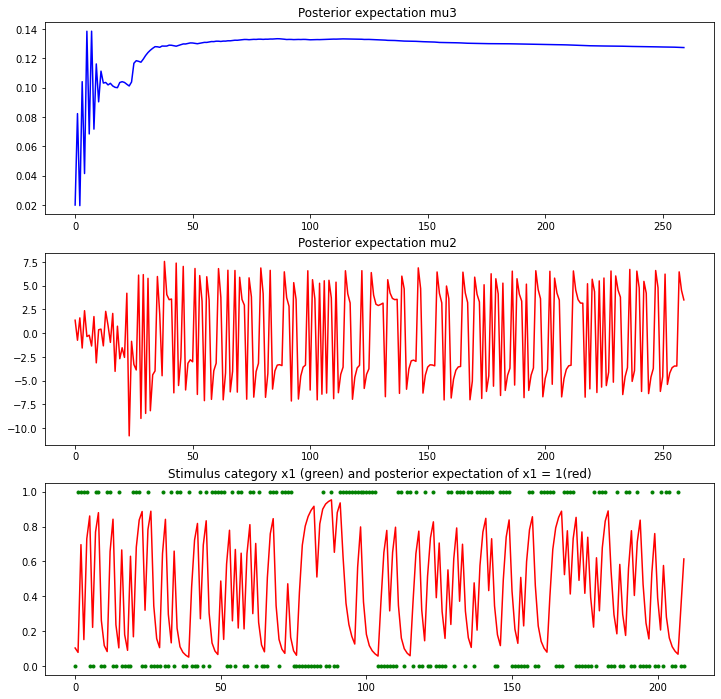

In [65]:
# show the bayesian optimial solutions:
fig, ax =plt.subplots(3,1, figsize=(12,12))
ax[0].plot(mu3, 'b')
ax[0].set_title('Posterior expectation mu3 ')
ax[1].plot(x2, 'r')
ax[1].set_title('Posterior expectation mu2 ')
ax[2].plot(model.sigmoid(mu2)[50:],'r')
ax[2].plot(u_adv, 'g.')
#ax[2].plot(u_bar[5*376:],'black')
ax[2].set_title('Stimulus category x1 (green) and posterior expectation of x1 = 1(red)')

plt.show()

In [66]:
ur = np.array(mu2v)

In [67]:
### get bayesian optimal model for input signals from advisor
yv=[]
x2v=[]
x3v=[]
mu =[]
mu2v=[]
mu3v=[]
var2v=[]
var3v=[]
wv=[]
kv=[]
thetav=[]
p1v=[]
p2v=[]
# initals for model states and parameters
x2 = .1
x3= 0.02
mu2=0.2
mu3=0.1
var2=.25
var3=.08
w= .1
k=.4
theta= .04

# a vettor with all states and parameters for fitting
X = np.array([x3,mu3, var3, theta, x2, mu2, var2, k, w])

# initial for grad and hess
grad = np.zeros((9,))
hess = np.zeros((9,))

# fitting
for i in range(50+len(u_adv)):
    #print(i)
    if i <50:
      v=u_test[i]
    else:
      v=u_adv[i-50]
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]


    # calculate the grad and hess at the top level
    grad_t, hess_t = model.hess_grad_top(x3, mu3, var3, theta)
    # update total grad and hess
    grad[:4] = grad_t
    hess[:4] = hess_t
    
    # calculate the grad and hess at mid levels
    grad_m, hess_m = model.hess_grad_mid(x2, mu2, var2, k, w, x3)
    # update the total grad and hess
    grad[4:] = grad_m[:5]
    hess[4:] = hess_m[:5]
    grad[0] += grad_m[-1] # update grad on x3 from this level
    hess[0] += hess_m[-1] # update hess on x3 from this level

    

    # update model states and parameters by Euler method
    X = model.update(v, X, grad, hess)
    
    # making sure the var2 var3 and theta are positive 
    X[2] = model.relu(X[2])
    X[3] = model.relu(X[3])
    X[6] = model.relu(X[6])
    
    # save the new states and model parameters
    x3 = X[0]
    mu3=X[1]
    var3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    var2=X[6]
    k=X[7]
    w=X[8]
    
    x2v.append(x2)
    x3v.append(x3)
    mu2v.append(mu2)
    mu3v.append(mu3)
    var2v.append(var2)
    var3v.append(var3)
    wv.append(w)
    kv.append(k)
    thetav.append(theta)

In [68]:
ut= np.array(mu2v)

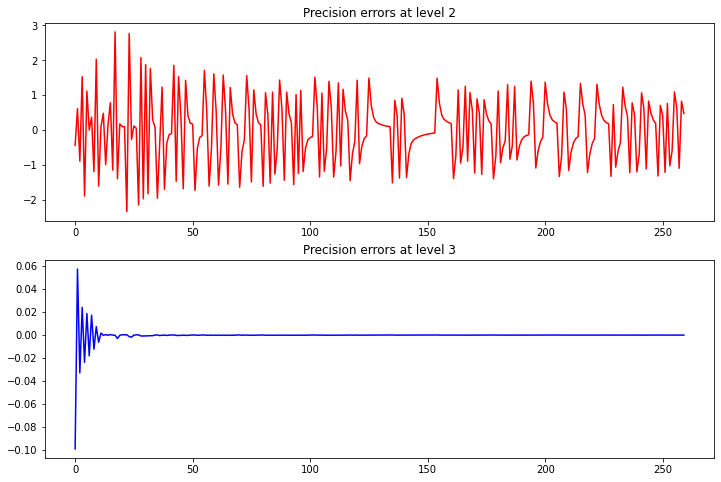

In [69]:
# calculate PE signals and show them
x2 =np.array(x2v)
k =np.array(kv)
w =np.array(wv)

x3 =np.array(x3v)
var2 =np.array(var2v)
var3 =np.array(var3v)
theta =np.array(thetav)
mu2 =np.array(mu2v)
mu3 =np.array(mu3v)

sigma_x = model.sigmoid(x2)
sigma_dx = model.sigmoid_dx(x2)
sigma_dxx = model.sigmoid_dxx(x2)
var2hat = var2+np.exp(k*x3+w)
var3hat = var3+theta
s2 = (x2-mu2)/np.sqrt(var2hat)
s3 = (x3-mu3)/np.sqrt(var3hat)
fig, ax =plt.subplots(2,1, figsize=(12,8))

ax[0].plot(-s2, 'r')
ax[0].set_title('Precision errors at level 2')
ax[1].plot(-s3, 'b')
ax[1].set_title('Precision errors at level 3')

plt.show()

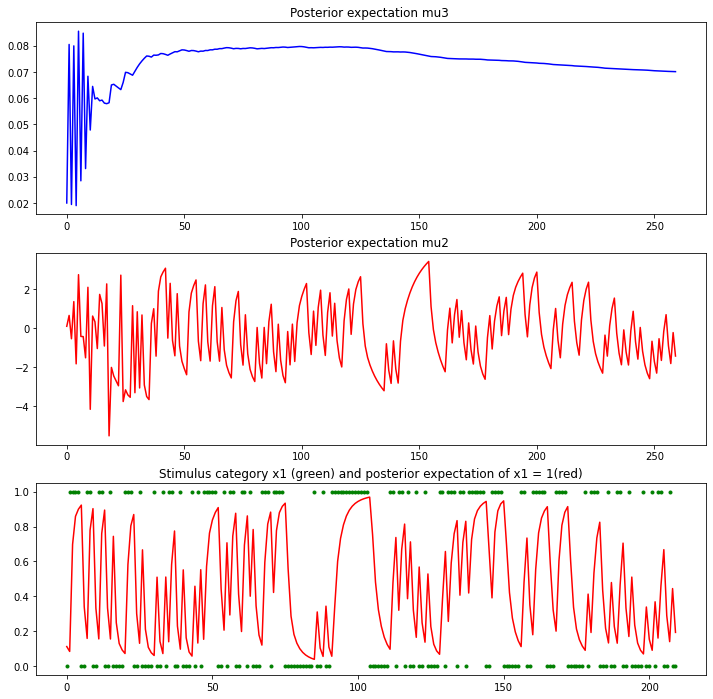

In [70]:
# show the bayesian optimial solutions:
fig, ax =plt.subplots(3,1, figsize=(12,12))
ax[0].plot(mu3, 'b')
ax[0].set_title('Posterior expectation mu3 ')
ax[1].plot(mu2, 'r')
ax[1].set_title('Posterior expectation mu2 ')
ax[2].plot(model.sigmoid(mu2)[50:],'r')
ax[2].plot(u_adv, 'g.')
#ax[2].plot(u_bar[5*376:],'black')
ax[2].set_title('Stimulus category x1 (green) and posterior expectation of x1 = 1(red)')

plt.show()

In [71]:
#ur = np.array(mu2v)
x2v=[]
x3v=[]

mu2v=[]
mu3v=[]

sigma2v=[]
sigma3v=[]
wv=[]
kv=[]
thetav=[]

pv=[]


x2 = .1
x3= 0.02
mu2=.02
mu3=0.1
sigma2=.5
sigma3=.08
w= 1.1
k=0.4
theta= .2
p=1.2



X = np.array([x3,mu3, sigma3, theta, x2, mu2, sigma2, k, w, p])
grad = np.zeros((10,))
hess = np.zeros((10,))
for i in range(ut.shape[0]):
    print(i)
    v=ur[i]
    vu = ut[i]
    if i< 50:
      vy =0.5
    else:
      vy=uy[i-50]
    x3 = X[0]
    mu3=X[1]
    sigma3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    sigma2=X[6]
    k=X[7]
    w=X[8]
    
    p = X[9]
    grad_t, hess_t = model.hess_grad_top(x3, mu3, sigma3, theta)
    grad[:4] = grad_t
    hess[:4] = hess_t
    grad_m, hess_m = model.hess_grad_mid_res(x2, mu2, sigma2, k, w, p, x3, v, vu)
    grad[4:] = grad_m[:6]
    hess[4:] = hess_m[:6]
    grad[0] += grad_m[-1]
    hess[0] += hess_m[-1]

    


    X = model.update(vy, X, grad, hess)

    X[2] = model.relu(X[2])
    X[3] = model.relu(X[3])
    X[6] = model.relu(X[6])
    X[9] = model.relu(X[9])
    

    x3 = X[0]
    mu3=X[1]
    sigma3=X[2]
    theta=X[3]
    x2 = X[4]
    mu2=X[5]
    sigma2=X[6]
    k=X[7]
    w=X[8]
    p = X[9]
    
    
    
    x2v.append(x2)
    x3v.append(x3)
    
    mu2v.append(mu2)
    mu3v.append(mu3)
    
    sigma2v.append(sigma2)
    sigma3v.append(sigma3)
    wv.append(w)
    pv.append(p)
    
    kv.append(k)
    thetav.append(theta)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259


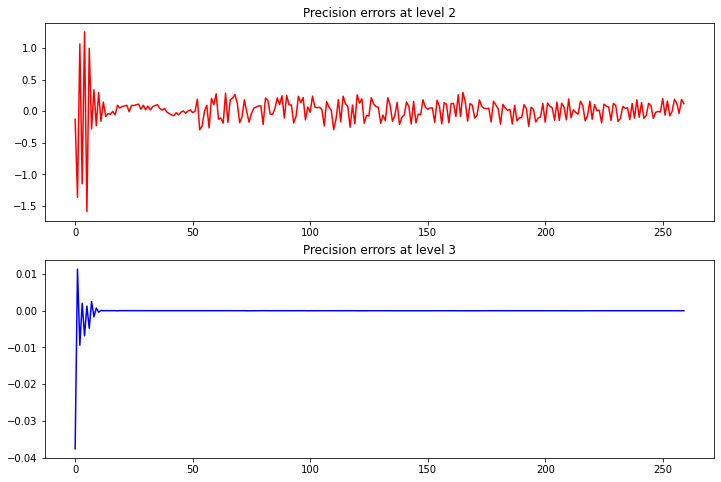

In [73]:
x2 =np.array(x2v)
k_p =np.array(kv)
w =np.array(wv)
p =np.array(pv)

x3 =np.array(x3v)
sigma2 =np.array(sigma2v)
sigma3 =np.array(sigma3v)
theta =np.array(thetav)
mu2 =np.array(mu2v)
mu3 =np.array(mu3v)


sigma_x = model.sigmoid(x2)
sigma_dx = model.sigmoid_dx(x2)
sigma_dxx = model.sigmoid_dxx(x2)
sigma2hat = sigma2+np.exp(k*x3+w)
sigma3hat = sigma3+theta
s2 = (x2-mu2)/sigma2hat
s3 = (x3-mu3)/sigma3hat
fig, ax =plt.subplots(2,1, figsize=(12,8))

ax[0].plot(-s2, 'r')
ax[0].set_title('Precision errors at level 2')
ax[1].plot(-s3, 'b')
ax[1].set_title('Precision errors at level 3')

plt.show()

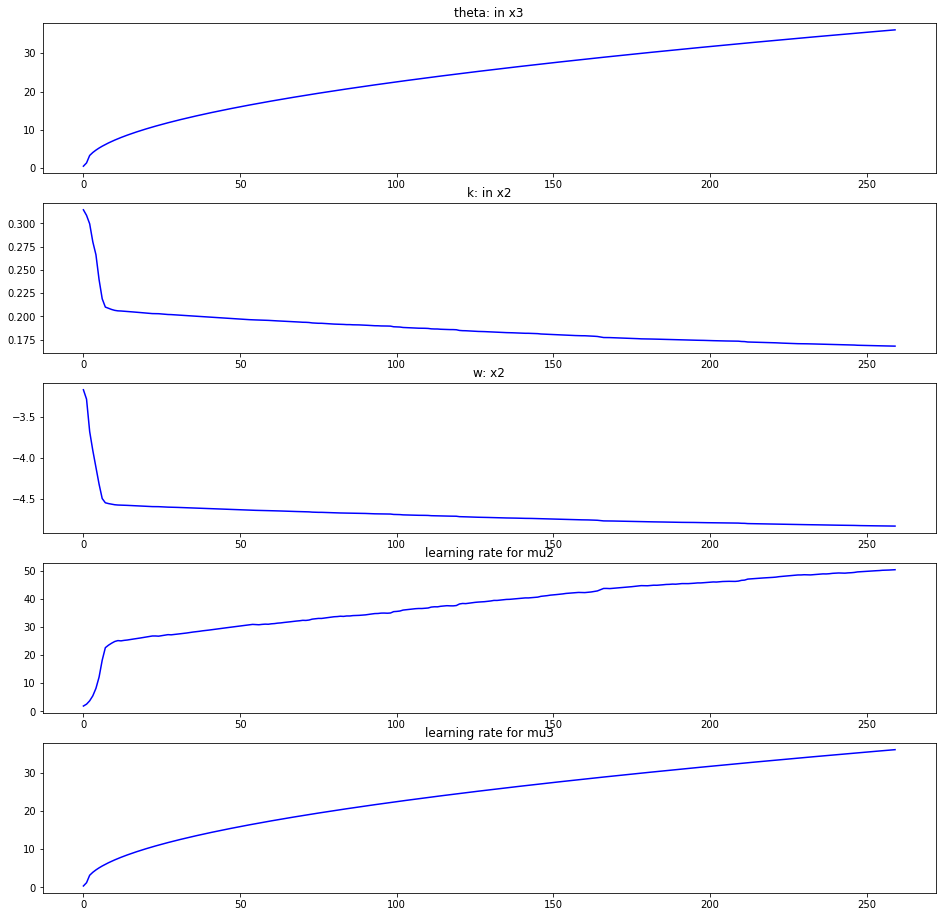

In [74]:
fig, ax =plt.subplots(5,1, figsize=(16,16))
ax[0].plot(theta, 'b')
ax[0].set_title('theta: in x3')
ax[1].plot(k_p,'b')
ax[1].set_title('k: in x2')
ax[2].plot(w,'b')
ax[2].set_title('w: x2')
ax[3].plot(sigma2,'b')
ax[3].set_title('learning rate for mu2')
ax[4].plot(sigma3,'b')
ax[4].set_title('learning rate for mu3')
plt.show()

In [75]:
ub=np.array(-s2[50:])

ud =np.array(mu2[50:])


In [76]:
ub_arr = np.zeros((210,3))
ub_arr[:,0] = ub/np.max(np.abs(ub))

ub_arr[:,1] = ud/np.max(np.abs(ud))
ub_arr[:,1] = uy[:,0]

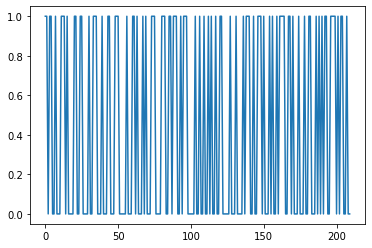

In [77]:
fig, ax = plt.subplots(1,1)
ax.plot(ub_arr[:,1].T)
plt.show()

In [ ]:
np.save('behav/DMPAD_168_inputs_behav_hgf.npy', ub_arr)